## Task 1

Investigation conducted in Bolon-Canedo et.al (2012). Evaluating various feature selection methods on synthetic datasets with known important and redundant attributes

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import (
    mutual_info_classif, RFE, RFECV, SelectKBest, 
    f_classif, chi2, SequentialFeatureSelector
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')


## Generatin the Synthetic Classification Dataset

The `generate_synthetic_classification_data` function builds a balanced, binary classification dataset with multiple feature types for testing and benchmarking machine-learning pipelines. It leverages Scikit-learn’s `make_classification` under the hood and then augments the data with correlated, noisy, and duplicate features.

### Key Feature Types

- **Informative features**  
  Core signals that determine the class label.  
- **Redundant features**  
  Linear combinations of the informative features (provided directly by `make_classification`).  
- **Correlated features**  
  Noisy versions of randomly chosen informative features, controlled by a correlation strength.  
- **Noisy features**  
  Pure Gaussian noise, uncorrelated with the labels.  
- **Duplicate features**  
  Exact copies of randomly selected informative features.

In [ ]:
def generate_synthetic_classification_data(
    n_samples: int = 1000,
    n_informative: int = 9,
    n_redundant: int = 20,
    n_correlated: int = 5,
    n_noisy: int = 5,
    n_duplicates: int = 5,
    noise_level: float = 0.1,
    correlation_strength: float = 0.7,
    random_state: int = 42
):
    
    
    np.random.seed(random_state)
    
    # Step 1: Generate base dataset with informative and redundant features
    # make_classification creates informative features by:
    # - Generating random coefficients for each class
    # - Creating decision boundary through linear combination
    # - Adding redundant features as linear combinations of informative ones
    X_base, y = make_classification(
        n_samples=n_samples,
        n_features=n_informative + n_redundant,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_clusters_per_class=1,
        n_classes=2,
        weights=[0.5, 0.5],
        class_sep=1.0,
        flip_y=0.01,#label noise for realism
        random_state=random_state
    )
    
    X_informative = X_base[:, :n_informative]
    
    feature_matrices = [X_informative]
    if n_redundant > 0:
        X_redundant = X_base[:, n_informative:n_informative + n_redundant]
        feature_matrices.append(X_redundant)
    if n_correlated > 0:
        X_correlated = []
        correlated_indices = np.random.choice(n_informative, size=n_correlated, replace=True)
    
        for i in range(n_correlated):
            base_feature = X_informative[:, correlated_indices[i]]
            # Add noise while maintaining correlation
            noise = np.random.normal(0, noise_level, n_samples)
            correlated_feature = correlation_strength * base_feature + (1 - correlation_strength) * noise
            X_correlated.append(correlated_feature)
        
        X_correlated = np.column_stack(X_correlated) if X_correlated else np.empty((n_samples, 0))
        feature_matrices.append(X_correlated)
    if n_noisy > 0:
        X_noisy = np.random.normal(0, 1, (n_samples, n_noisy))
        feature_matrices.append(X_noisy)
    if n_duplicates > 0:
        duplicate_indices = np.random.choice(n_informative, size=n_duplicates, replace=True)
        X_duplicates = X_informative[:, duplicate_indices] if n_duplicates > 0 else np.empty((n_samples, 0))
        feature_matrices.append(X_duplicates)
    
    X_combined = np.column_stack(feature_matrices)


    feature_info = list(range(n_informative))

    print(f"Generated dataset with {X_combined.shape[0]} samples and {X_combined.shape[1]} features.")
    print(type(X_combined), type(y))
    
    return X_combined, y, feature_info

### Feature‐Selection Methods

In this section, we compare **six** feature‐selection techniques drawn from the three major categories in Bolón-Canedo et al. (2012):

1. **Filters**  
   - **Mutual Information** (`mutual_info_classif`)  
     A non-parametric filter that ranks features by how much “information” they share with the class label. We pick the top *k* features by highest MI score.  
   - **Correlation-based** (`pearsonr`)  
     Computes the absolute Pearson correlation between each feature and the target. The top *k* features with highest |r| are selected.

2. **Wrappers**  
   - **Recursive Feature Elimination (RFE)**  
     Wraps a logistic‐regression estimator and recursively removes the least-important feature until only *k* remain.  
   - **Sequential Forward Selection** (`SequentialFeatureSelector`)  
     Greedily adds one feature at a time—each chosen for the biggest incremental boost in CV accuracy—until reaching *k* features.

3. **Embedded (Model-Based)**  
   - **Random Forest Importance**  
     Trains a Random Forest and selects the *k* features with highest mean decrease in impurity (feature_importances_).  
   - **LASSO** (`LassoCV` + `SelectFromModel`)  
     Fits a logistic‐LASSO model (L1 penalty), then keeps the *k* features whose coefficients have the largest absolute magnitude.

Each method returns:  
- A list of the selected feature indices  
- Filtered training/test matrices (`X_train[:, selected]`, `X_test[:, selected]`)  
- A “Success Index” (%) measuring overlap with a known ground-truth feature set  


# Evaluation
 Each of the feature selection methods is evaluated on two models, SVM (Support Vector Machines) and Random Forests with measures such as accuracy, precision, recall and f1-score to identify the best feature selectors. Moreover, dimensionality reduction methods (PCA, MDS and tSNE). All of them are run on multiple runs and results are averaged for better stability. 

In [ ]:
class FeatureSelector:
    def __init__(self, X, y, relevant_features=None, random_state=42):
        """
        Initialize the comprehensive evaluator
        
        Parameters:
        X: Feature matrix
        y: Target variable
        relevant_features: List of indices of truly relevant features
        """
        self.X = X
        self.y = y
        self.relevant_features = relevant_features or []
        self.irrelevant_features = [i for i in range(X.shape[1]) if i not in self.relevant_features]
        self.random_state = random_state
        self.feature_selection_results = {}
        self.classification_results = {}
        
    def calculate_success_index(self, selected_features, alpha=None):
        """Calculate Success Index as defined in Bolón-Canedo et al. (2012)"""
        Rs = len(set(selected_features) & set(self.relevant_features))
        Rt = len(self.relevant_features)
        Is = len(set(selected_features) & set(self.irrelevant_features))
        It = len(self.irrelevant_features)
        
        if alpha is None:
            alpha = min(0.5, Rt / It if It > 0 else 0.5)
        
        if Rt == 0:
            return 0
            
        success = (Rs / Rt - alpha * (Is / It if It > 0 else 0)) * 100
        return max(0, success)
    
    def evaluate_classifier(self, X_train, X_test, y_train, y_test, classifier_name="Classifier"):
        """Evaluate both SVM and Random Forest classifiers"""
        results = {}
        
        # Initialize classifiers
        classifiers = {
            'SVM': SVC(random_state=self.random_state, probability=True),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=self.random_state)
        }
        
        for clf_name, clf in classifiers.items():
            # Fit and predict
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            
            results[clf_name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            }
        
        return results
    
    def apply_feature_selection_methods(self, X_train, X_test, y_train, k=10):
        """Apply all feature selection methods and return selected features"""
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        methods_results = {}
        
        # 1. Mutual Information (Filter)
        mi_scores = mutual_info_classif(X_train, y_train, random_state=self.random_state)
        mi_selected = np.argsort(mi_scores)[-k:]
        methods_results['Mutual Information'] = {
            'selected_features': mi_selected,
            'X_train': X_train[:, mi_selected],
            'X_test': X_test[:, mi_selected],
            'success_index': self.calculate_success_index(mi_selected)
        }
        
        # 2. Correlation-based (Filter)
        correlations = []
        for i in range(X_train.shape[1]):
            corr, _ = pearsonr(X_train[:, i], y_train)
            correlations.append(abs(corr))
        corr_selected = np.argsort(correlations)[-k:]
        methods_results['Correlation-based'] = {
            'selected_features': corr_selected,
            'X_train': X_train[:, corr_selected],
            'X_test': X_test[:, corr_selected],
            'success_index': self.calculate_success_index(corr_selected)
        }
        
        # 3. RFE (Wrapper)
        estimator = LogisticRegression(random_state=self.random_state, max_iter=1000)
        rfe = RFE(estimator, n_features_to_select=k)
        rfe.fit(X_train_scaled, y_train)
        rfe_selected = np.where(rfe.support_)[0]
        methods_results['RFE'] = {
            'selected_features': rfe_selected,
            'X_train': X_train_scaled[:, rfe_selected],
            'X_test': X_test_scaled[:, rfe_selected],
            'success_index': self.calculate_success_index(rfe_selected)
        }
        
        # 4. Sequential Feature Selection (Wrapper)
        estimator = LogisticRegression(random_state=self.random_state, max_iter=1000)
        sfs = SequentialFeatureSelector(
            estimator, n_features_to_select=k, direction='forward', cv=3, scoring='accuracy'
        )
        sfs.fit(X_train_scaled, y_train)
        sfs_selected = np.where(sfs.get_support())[0]
        methods_results['Sequential FS'] = {
            'selected_features': sfs_selected,
            'X_train': X_train_scaled[:, sfs_selected],
            'X_test': X_test_scaled[:, sfs_selected],
            'success_index': self.calculate_success_index(sfs_selected)
        }
        
        # 5. Random Forest Feature Importance (Model-based)
        rf = RandomForestClassifier(n_estimators=100, random_state=self.random_state)
        rf.fit(X_train, y_train)
        rf_selected = np.argsort(rf.feature_importances_)[-k:]
        methods_results['Random Forest FS'] = {
            'selected_features': rf_selected,
            'X_train': X_train[:, rf_selected],
            'X_test': X_test[:, rf_selected],
            'success_index': self.calculate_success_index(rf_selected)
        }
        
        # 6. LASSO (Model-based)
        from sklearn.linear_model import LassoCV
        lasso = LassoCV(cv=5, random_state=self.random_state, max_iter=2000)
        lasso.fit(X_train_scaled, y_train)
        lasso_selected = np.argsort(np.abs(lasso.coef_))[-k:]
        methods_results['LASSO'] = {
            'selected_features': lasso_selected,
            'X_train': X_train_scaled[:, lasso_selected],
            'X_test': X_test_scaled[:, lasso_selected],
            'success_index': self.calculate_success_index(lasso_selected)
        }
        
        return methods_results, scaler
    
    def apply_dimensionality_reduction(self, X_train, X_test, y_train, n_components=10):
        """Apply dimensionality reduction techniques"""
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        reduction_results = {}
        
        # 1. PCA
        pca = PCA(n_components=n_components, random_state=self.random_state)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        reduction_results['PCA'] = {
            'X_train': X_train_pca,
            'X_test': X_test_pca,
            'explained_variance': pca.explained_variance_ratio_.sum()
        }
        
        # 2. MDS (Multidimensional Scaling)
        mds = MDS(n_components=n_components, random_state=self.random_state, max_iter=1000)
        X_train_mds = mds.fit_transform(X_train_scaled)
        # For test set, we need to use a different approach since MDS doesn't have transform method
        X_combined = np.vstack([X_train_scaled, X_test_scaled])
        X_combined_mds = MDS(n_components=n_components, random_state=self.random_state, max_iter=1000).fit_transform(X_combined)
        X_test_mds = X_combined_mds[len(X_train_scaled):]
        X_train_mds = X_combined_mds[:len(X_train_scaled)]
        
        reduction_results['MDS'] = {
            'X_train': X_train_mds,
            'X_test': X_test_mds,
            'stress': mds.stress_ if hasattr(mds, 'stress_') else None
        }
        
        # 3. t-SNE (only for visualization, not for classification due to its nature)
        # t-SNE is typically used for visualization and doesn't have a transform method
        tsne = TSNE(n_components=min(n_components, 3), random_state=self.random_state, max_iter=1000)
        X_combined_tsne = tsne.fit_transform(X_combined)
        X_test_tsne = X_combined_tsne[len(X_train_scaled):]
        X_train_tsne = X_combined_tsne[:len(X_train_scaled)]
        
        reduction_results['t-SNE'] = {
            'X_train': X_train_tsne,
            'X_test': X_test_tsne,
            'kl_divergence': tsne.kl_divergence_
        }
        
        return reduction_results
    
    def run_single_experiment(self, k_features=10, n_components=10):
        """Run a single experiment with train/test split"""
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.3, random_state=self.random_state, stratify=self.y
        )
        
        results = {}
        
        # 1. All features
        scaler_all = StandardScaler()
        X_train_all = scaler_all.fit_transform(X_train)
        X_test_all = scaler_all.transform(X_test)
        
        results['All Features'] = self.evaluate_classifier(X_train_all, X_test_all, y_train, y_test)
        
        # 2. Only relevant features
        if self.relevant_features:
            X_train_relevant = X_train[:, self.relevant_features]
            X_test_relevant = X_test[:, self.relevant_features]
            scaler_rel = StandardScaler()
            X_train_relevant = scaler_rel.fit_transform(X_train_relevant)
            X_test_relevant = scaler_rel.transform(X_test_relevant)
            
            results['Relevant Features Only'] = self.evaluate_classifier(
                X_train_relevant, X_test_relevant, y_train, y_test
            )
        
        # 3. Feature selection methods
        fs_methods, scaler = self.apply_feature_selection_methods(X_train, X_test, y_train, k_features)
        
        for method_name, method_data in fs_methods.items():
            results[f'FS: {method_name}'] = self.evaluate_classifier(
                method_data['X_train'], method_data['X_test'], y_train, y_test
            )
            results[f'FS: {method_name}']['success_index'] = method_data['success_index']
        
        # 4. Dimensionality reduction
        dr_methods = self.apply_dimensionality_reduction(X_train, X_test, y_train, n_components)
        
        for method_name, method_data in dr_methods.items():
            results[f'DR: {method_name}'] = self.evaluate_classifier(
                method_data['X_train'], method_data['X_test'], y_train, y_test
            )
        
        return results
    
    def run_multiple_experiments(self, n_runs=5, k_features=10, n_components=10):
        """Run multiple experiments and average results"""
        print(f"Running {n_runs} experiments")
        print(f"Dataset: {self.X.shape[0]} samples, {self.X.shape[1]} features")
        print(f"Relevant features: {len(self.relevant_features)}")
        print(f"Selecting {k_features} features, reducing to {n_components} components")
        
        all_results = []
        
        for run in range(n_runs):
            print(f"Run {run + 1}/{n_runs}...")
            self.random_state = 42 + run  # Different random state for each run
            single_result = self.run_single_experiment(k_features, n_components)
            all_results.append(single_result)
        
        averaged_results = self.average_results(all_results)
        self.classification_results = averaged_results
        
        return averaged_results
    
    def average_results(self, all_results):
        """Average results across multiple runs"""
        averaged = {}
        
        all_methods = set()
        for result in all_results:
            all_methods.update(result.keys())
        
        for method in all_methods:
            averaged[method] = {}
            
            all_classifiers = set()
            for result in all_results:
                if method in result:
                    all_classifiers.update(result[method].keys())
            
            for classifier in all_classifiers:
                if classifier == 'success_index':
                    # Handle success index separately
                    values = [result[method].get(classifier, 0) for result in all_results if method in result]
                    averaged[method][classifier] = {
                        'mean': np.mean(values),
                        'std': np.std(values)
                    }
                else:
                    # Handle metrics
                    averaged[method][classifier] = {}
                    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
                    
                    for metric in metrics:
                        values = []
                        for result in all_results:
                            if method in result and classifier in result[method]:
                                values.append(result[method][classifier].get(metric, 0))
                        
                        if values:
                            averaged[method][classifier][metric] = {
                                'mean': np.mean(values),
                                'std': np.std(values)
                            }
        
        return averaged
    
    def create_results_table(self):
        """Create a results table"""
        if not self.classification_results:
            return "No results available. Run experiments first."
        
        table_data = []
        
        for method_name, method_results in self.classification_results.items():
            for classifier_name, classifier_results in method_results.items():
                if classifier_name == 'success_index':
                    continue
                
                row = {
                    'Method': method_name,
                    'Classifier': classifier_name,
                    'Accuracy': f"{classifier_results['accuracy']['mean']:.4f} ± {classifier_results['accuracy']['std']:.4f}",
                    'Precision': f"{classifier_results['precision']['mean']:.4f} ± {classifier_results['precision']['std']:.4f}",
                    'Recall': f"{classifier_results['recall']['mean']:.4f} ± {classifier_results['recall']['std']:.4f}",
                    'F1-Score': f"{classifier_results['f1_score']['mean']:.4f} ± {classifier_results['f1_score']['std']:.4f}"
                }
                
                # Add success index if available
                if 'success_index' in method_results:
                    row['Success Index'] = f"{method_results['success_index']['mean']:.2f} ± {method_results['success_index']['std']:.2f}"
                else:
                    row['Success Index'] = "N/A"
                
                table_data.append(row)
        
        return pd.DataFrame(table_data)
    
    def plot_comprehensive_comparison(self):
        """Create comprehensive comparison plots"""
        if not self.classification_results:
            print("No results to plot. Run experiments first.")
            return
        
        methods = []
        svm_accuracy = []
        rf_accuracy = []
        svm_f1 = []
        rf_f1 = []
        
        for method_name, method_results in self.classification_results.items():
            methods.append(method_name.replace('FS: ', '').replace('DR: ', ''))
            
            if 'SVM' in method_results:
                svm_accuracy.append(method_results['SVM']['accuracy']['mean'])
                svm_f1.append(method_results['SVM']['f1_score']['mean'])
            else:
                svm_accuracy.append(0)
                svm_f1.append(0)
            
            if 'Random Forest' in method_results:
                rf_accuracy.append(method_results['Random Forest']['accuracy']['mean'])
                rf_f1.append(method_results['Random Forest']['f1_score']['mean'])
            else:
                rf_accuracy.append(0)
                rf_f1.append(0)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
        
        x = np.arange(len(methods))
        width = 0.35
        
        # Accuracy comparison
        bars1 = ax1.bar(x - width/2, svm_accuracy, width, label='SVM', alpha=0.8, color='skyblue')
        bars2 = ax1.bar(x + width/2, rf_accuracy, width, label='Random Forest', alpha=0.8, color='lightcoral')
        ax1.set_title('Accuracy Comparison')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Methods')
        ax1.set_xticks(x)
        ax1.set_xticklabels(methods, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # F1-Score comparison
        bars3 = ax2.bar(x - width/2, svm_f1, width, label='SVM', alpha=0.8, color='skyblue')
        bars4 = ax2.bar(x + width/2, rf_f1, width, label='Random Forest', alpha=0.8, color='lightcoral')
        ax2.set_title('F1-Score Comparison')
        ax2.set_ylabel('F1-Score')
        ax2.set_xlabel('Methods')
        ax2.set_xticks(x)
        ax2.set_xticklabels(methods, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Success Index for Feature Selection methods
        fs_methods = []
        success_indices = []
        for method_name, method_results in self.classification_results.items():
            if 'FS:' in method_name and 'success_index' in method_results:
                fs_methods.append(method_name.replace('FS: ', ''))
                success_indices.append(method_results['success_index']['mean'])
        
        if fs_methods:
            bars5 = ax3.bar(fs_methods, success_indices, alpha=0.8, color='lightgreen')
            ax3.set_title('Success Index - Feature Selection Methods')
            ax3.set_ylabel('Success Index')
            ax3.set_xlabel('Feature Selection Methods')
            plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
            ax3.grid(True, alpha=0.3)
        
        # Heatmap of all metrics
        heatmap_data = []
        heatmap_methods = []
        
        for method_name, method_results in self.classification_results.items():
            if 'SVM' in method_results:
                heatmap_methods.append(f"{method_name} (SVM)")
                heatmap_data.append([
                    method_results['SVM']['accuracy']['mean'],
                    method_results['SVM']['precision']['mean'],
                    method_results['SVM']['recall']['mean'],
                    method_results['SVM']['f1_score']['mean']
                ])
            
            if 'Random Forest' in method_results:
                heatmap_methods.append(f"{method_name} (RF)")
                heatmap_data.append([
                    method_results['Random Forest']['accuracy']['mean'],
                    method_results['Random Forest']['precision']['mean'],
                    method_results['Random Forest']['recall']['mean'],
                    method_results['Random Forest']['f1_score']['mean']
                ])
        
        heatmap_df = pd.DataFrame(heatmap_data, 
                                  index=heatmap_methods,
                                  columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
        
        sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax4)
        ax4.set_title('Performance Heatmap (All Metrics)')
        plt.setp(ax4.get_yticklabels(), rotation=0)
        
        plt.tight_layout()
        plt.show()




Generated dataset with 1000 samples and 24 features.
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Running 5 experiments...
Dataset: 1000 samples, 24 features
Relevant features: 8
Selecting 5 features, reducing to 5 components
Run 1/5...
Run 2/5...
Run 3/5...
Run 4/5...
Run 5/5...
                Method    Classifier        Accuracy       Precision          Recall        F1-Score Success Index
               DR: PCA Random Forest 0.9087 ± 0.0091 0.9090 ± 0.0091 0.9087 ± 0.0091 0.9086 ± 0.0091           N/A
               DR: PCA           SVM 0.9213 ± 0.0159 0.9224 ± 0.0152 0.9213 ± 0.0159 0.9213 ± 0.0159           N/A
  FS: Random Forest FS Random Forest 0.9373 ± 0.0039 0.9377 ± 0.0037 0.9373 ± 0.0039 0.9373 ± 0.0039  31.25 ± 0.00
  FS: Random Forest FS           SVM 0.9460 ± 0.0077 0.9465 ± 0.0074 0.9460 ± 0.0077 0.9460 ± 0.0077  31.25 ± 0.00
             FS: LASSO Random Forest 0.9467 ± 0.0114 0.9475 ± 0.0112 0.9467 ± 0.0114 0.9466 ± 0.0114  15.62 ± 0.00
             FS: LASSO    

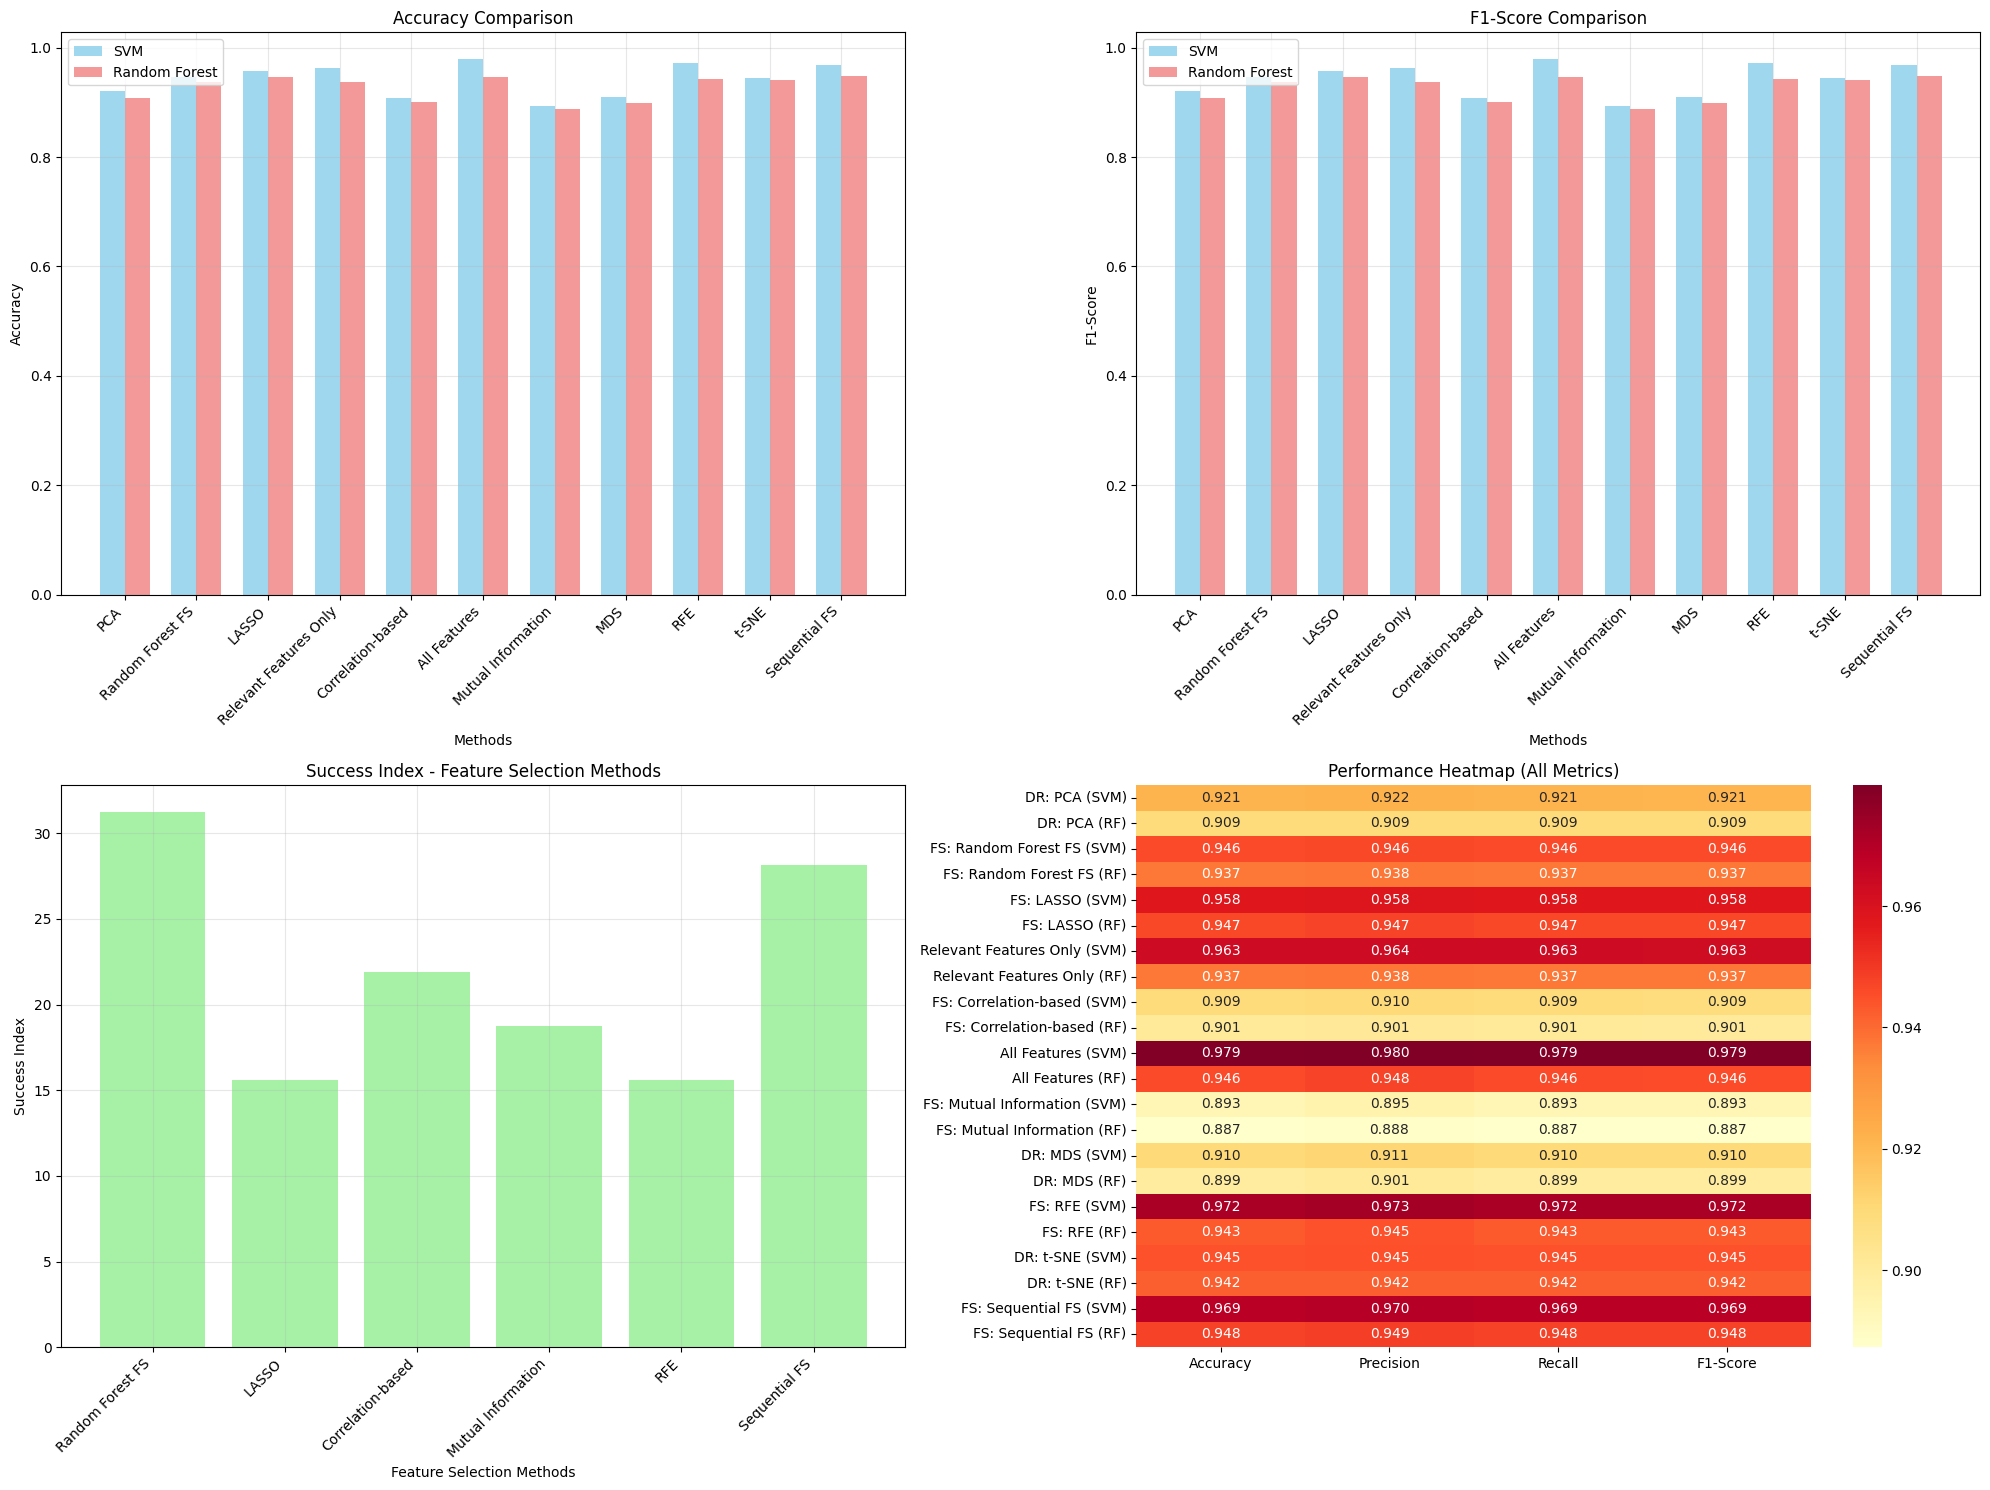

In [ ]:
informative_features = 8
n_samples = 1000
redundant_features = 4
duplicate_features = 2
noisy_features = 5


X, y, relevant_features = generate_synthetic_classification_data(n_informative=informative_features,
                                                                n_samples=n_samples,
                                                                n_redundant=redundant_features,
                                                                n_duplicates=duplicate_features,
                                                                n_noisy=noisy_features)

evaluator = FeatureSelector(X, y, relevant_features)
results = evaluator.run_multiple_experiments(n_runs=5, k_features=5, n_components=5)
results_table = evaluator.create_results_table()
print(results_table.to_string(index=False))

evaluator.plot_comprehensive_comparison()